# Piotr Styczyński NLP1
*NLP @ 24 Feb 2020*

The following code reads tab file from NKJP and calculates frequencies counts, plots them and tries to estimate Zipf coefficient for the given text data.

<IPython.core.display.Latex object>

property,value
case,Zipf curve for forms
Best coeffs from log likelihood,11.64 + x*-2.01
Curve slope,63.5


property,value
case,Zipf curve for lemmas
Best coeffs from log likelihood,10.12 + x*-1.62
Curve slope,58.33


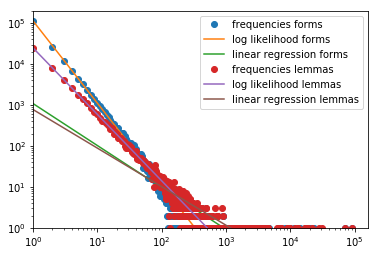

In [ ]:
import csv
import sys
import collections
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import linregress
import scipy

from format_utils import ListTable
from IPython.core.display import display

# Some fields overflow default CSV buffer so we set incredibly huge default
csv.field_size_limit(sys.maxsize)

for [case_no, case_name] in [[0, 'forms'], [1, 'lemmas']]:
    # Open input file
    freqs = dict()
    with open('1_NKJP1M-frequency.tab', newline = '') as file:
        reader = csv.reader(file, delimiter='\t', quoting=csv.QUOTE_NONE)
        counts = []
        if case_no == 0:
            counts = np.array([int(r[-1]) for r in reader])
        else:
            lem_freq = dict()
            for r in reader:
                if r[1] in lem_freq:
                    lem_freq[r[1]] += int(r[-1])
                else:
                    lem_freq[r[1]] = int(r[-1])
            counts = list(lem_freq.values())
        freqs = collections.Counter(counts)

    # Get x and y axis samples for plotting
    # this changes dict(key: count) into two lists [keys..] [counts..] that are sorted by keys
    # and creates numpy arrays from them
    [x, y] = map(np.array, map(list, zip(*sorted(freqs.items()))))

    # Function used for minimization
    def opt(alpha):
        p_i = x**(-alpha)
        return -(np.log(p_i / p_i.sum()) * y).sum()

    # We find optimal linear function by minimizing distance (see opt function)
    # This uses BFGS underneath and it's fine for this usage
    coeff = (-minimize(opt, [2]).x)[0]

    # Plot results
    plt.plot(x, y, 'o', label=f"frequencies {case_name}")
    plt.xscale("log")
    plt.yscale("log")

    # Trim axes of graph
    cc = y[0] * (x ** [coeff])
    plt.ylim(1)
    plt.xlim(1)
    plt.plot(x, cc, label=f"log likelihood {case_name}")

    # Plot also linear regression for comparison
    lr_a, lr_b, _, _, _ = scipy.stats.linregress(np.log(x), np.log(y))
    plt.ylim(1)
    plt.xlim(1)
    plt.plot(x, (np.e ** lr_b) * (x ** [lr_a]), label=f"linear regression {case_name}")
    plt.legend()

    # Helper to format float to string
    rf = lambda v: str(round(v, 2))
    # Helper function to convert radians to string with degrees
    coeff2angle = lambda coeff: rf(abs(np.arctan(coeff)/(2*np.pi)*360))

    # Find the linear function slope in degrees and print coeff
    l = ListTable()
    l.append(["property", "value"])
    l.append(["case", f"Zipf curve for {case_name}"])
    #l.append(["LR slope", coeff2angle(lr_a)])
    l.append(["Best coeffs from log likelihood", f"{rf(math.log(y[0]))} + x*{rf(coeff)}"])
    l.append(["Curve slope", coeff2angle(coeff)])
    print("\n")
    display(l)
